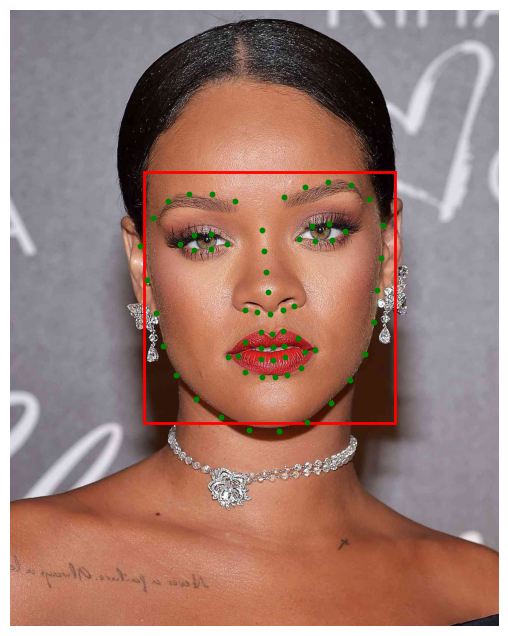

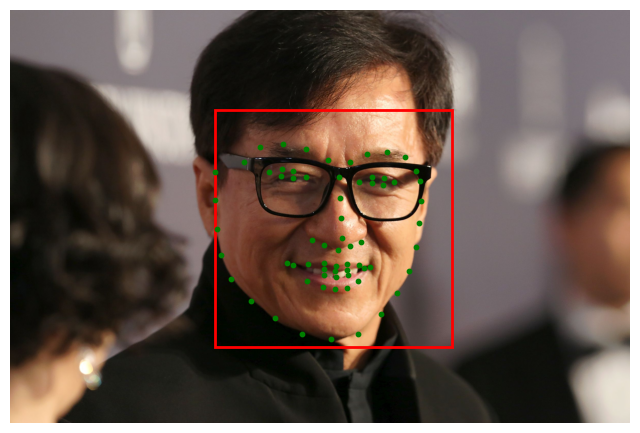

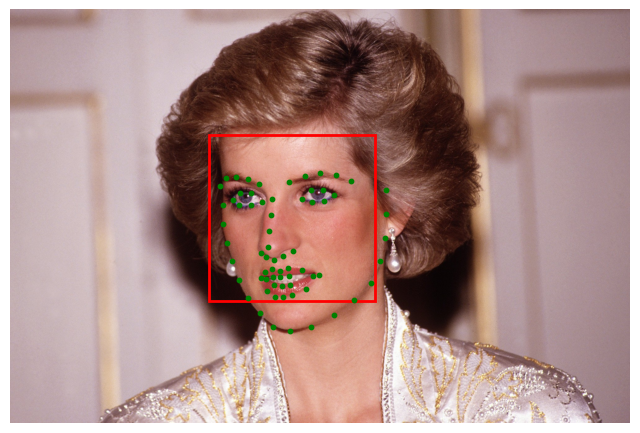

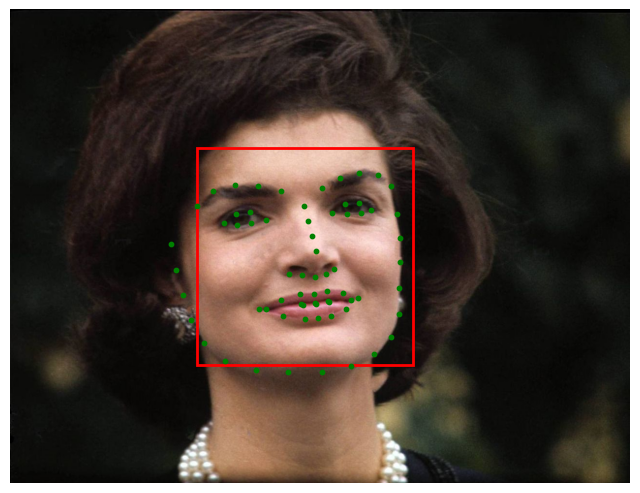

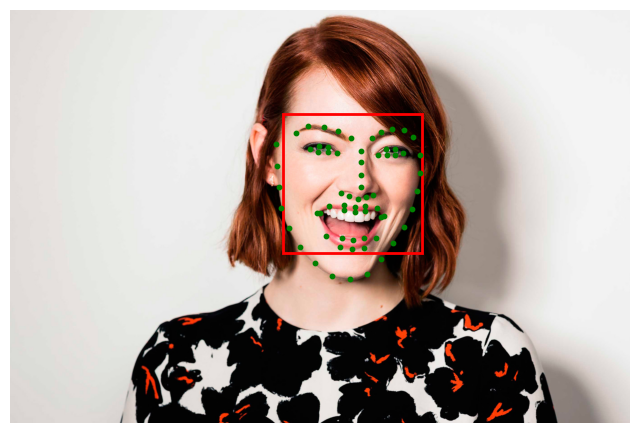

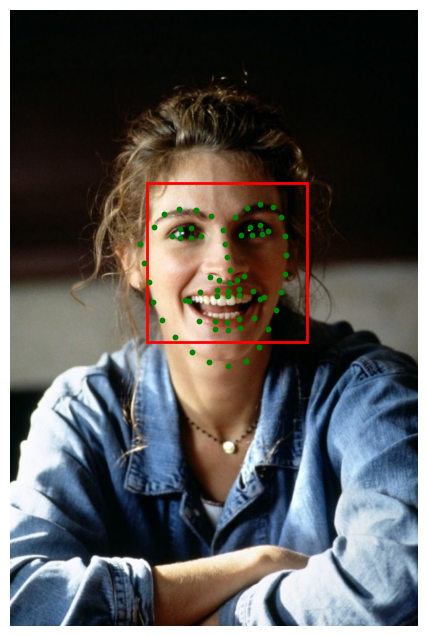

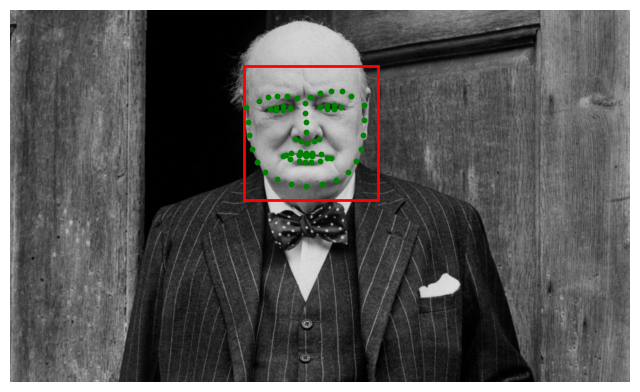

In [10]:
%matplotlib inline

import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import requests
import os
import bz2


input_file = "onecell_task/shape_predictor_68_face_landmarks.dat.bz2"
output_file = "onecell_task/shape_predictor_68_face_landmarks.dat"
if not os.path.exists(output_file):
    with bz2.BZ2File(input_file, "rb") as fr, open(output_file, "wb") as fw:
        fw.write(fr.read())


def load_img(file_path):
    img = cv2.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

images = [
    "onecell_task/rihanna.jpg",
    "onecell_task/chan.jpg",
    "onecell_task/diana.jpg",
    "onecell_task/kennedy.jpg",
    "onecell_task/emma.jpg",
    "onecell_task/roberts.jpg",
    "onecell_task/cherchill.png",
    "onecell_task/fellini.jpg",
    "onecell_task/tupolev.jpg",
    "onecell_task/shuhov.jpg",
    "onecell_task/sinatra.jpg",
    "onecell_task/sadness.jpeg",
    "onecell_task/tatcher.jpg",
    "onecell_task/evangelista.jpg",
]

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(output_file)


n = 7
for i in range(n):
    image = load_img(images[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        
        landmarks = predictor(gray, face)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')
        
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
        
        for n in range(68):
            x_lm = landmarks.part(n).x
            y_lm = landmarks.part(n).y
            plt.scatter(x_lm, y_lm, color='green', s=10)
        
        plt.show()


Average MSE for all points: 528.8392713474209


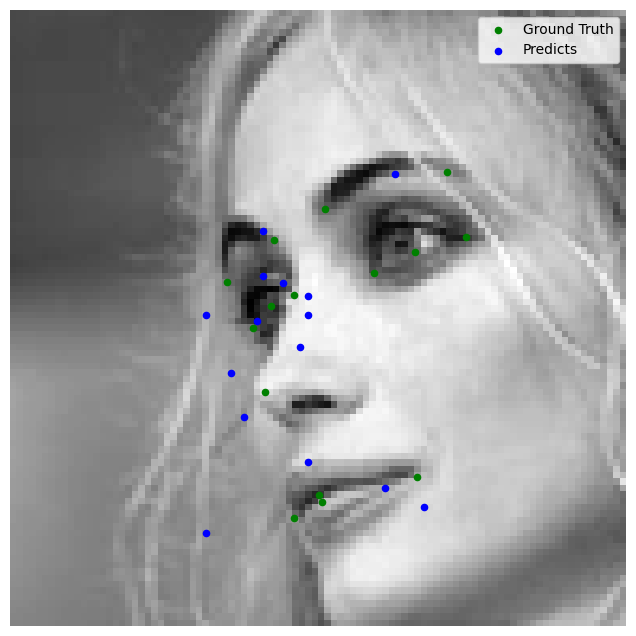

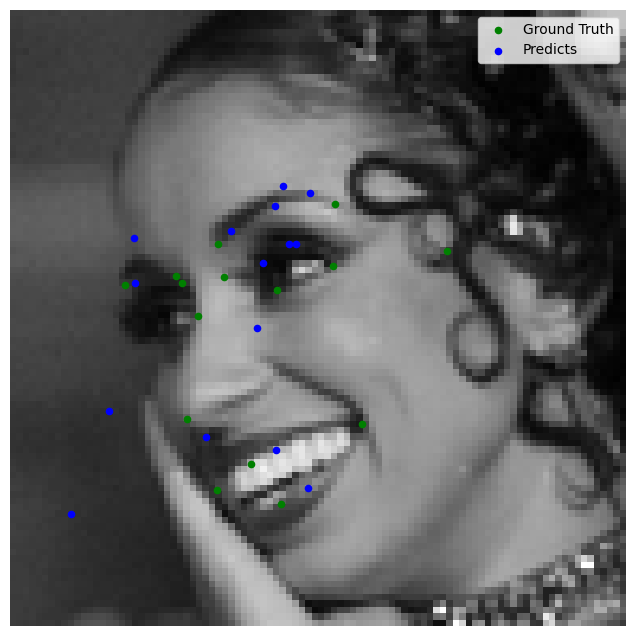

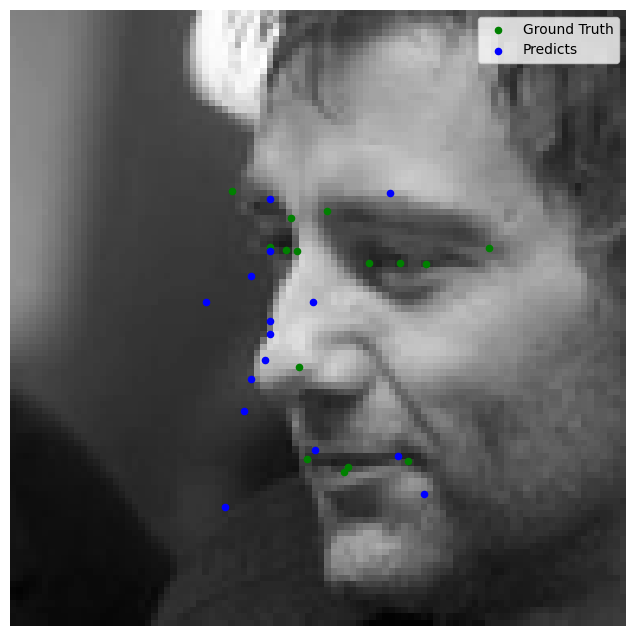

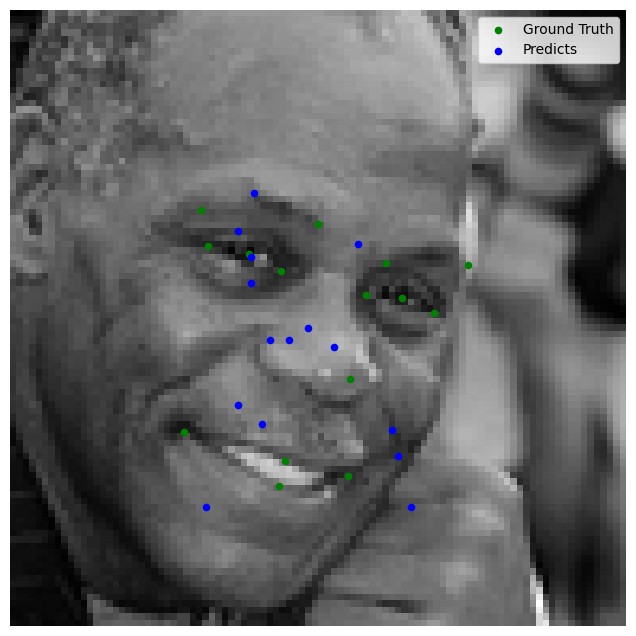

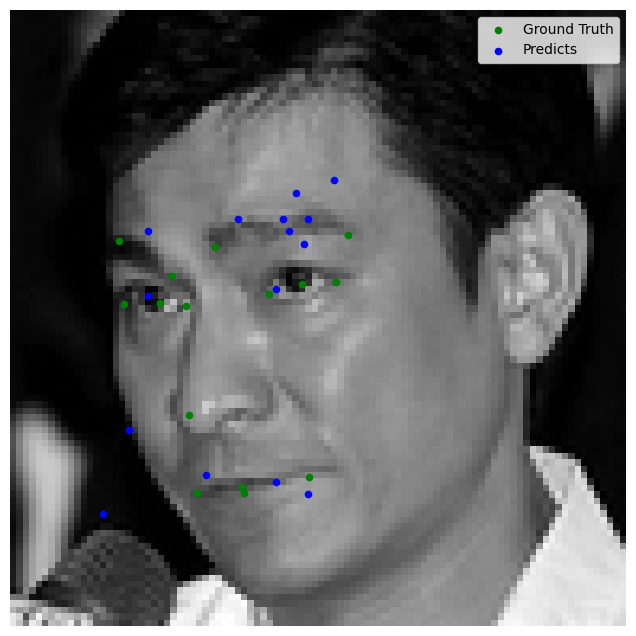

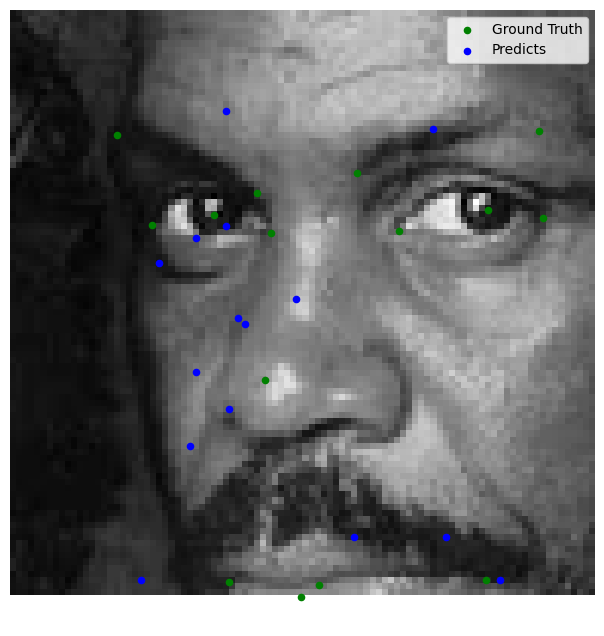

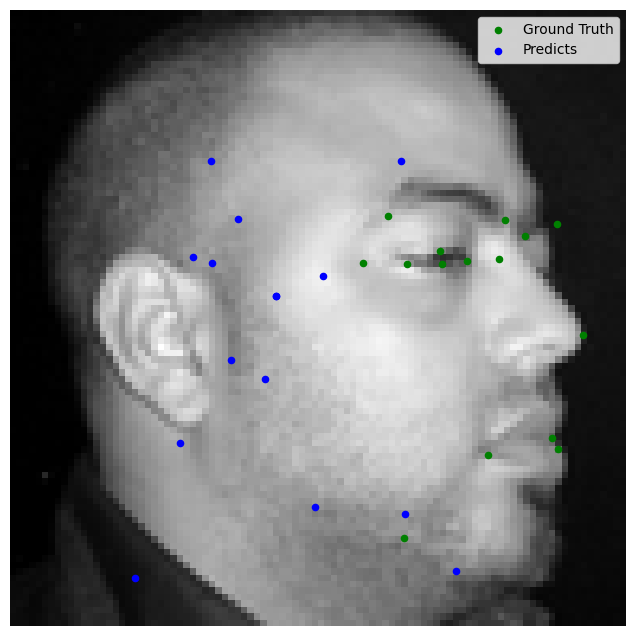

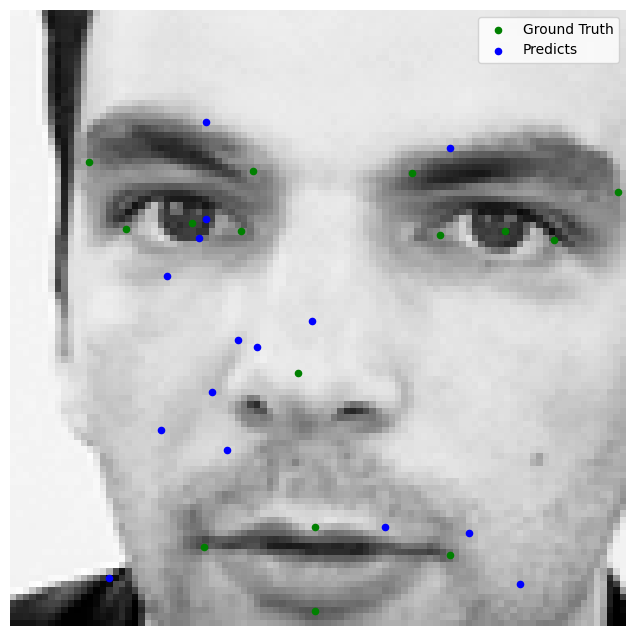

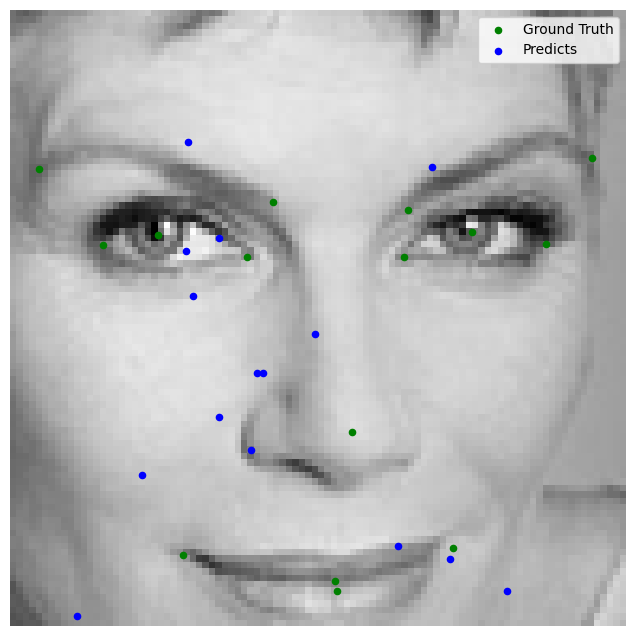

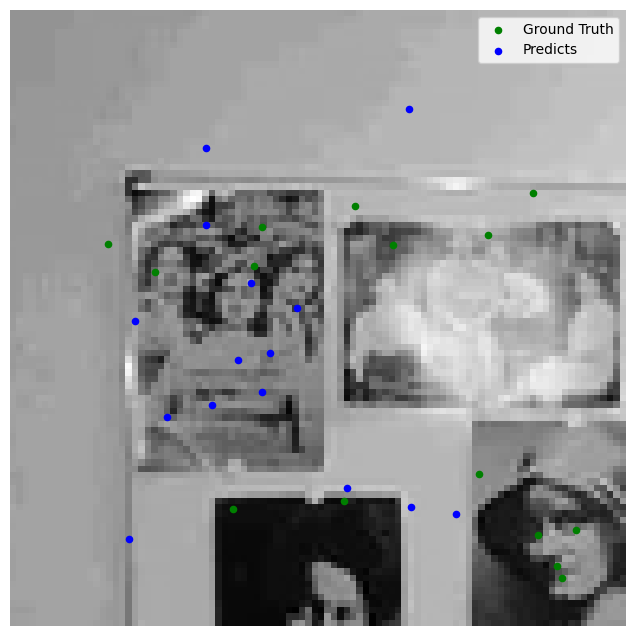

Mean detection accuracy for all points: 0.0027237906085969643
Mean positioning error for all points: 30.13489062873447


In [15]:
import pandas as pd
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

training = pd.read_csv('onecell_task/training.csv')
test = pd.read_csv('onecell_task/test.csv')
submission = pd.read_csv('onecell_task/SampleSubmission.csv')

training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape(96, 96).astype(np.uint8))
columns = [
    'left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y',
    'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
    'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
    'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
    'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
    'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y',
    'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'
]

training.ffill(inplace=True)

mapping = {
    'left_eye_center': [38, 39, 40, 41],
    'right_eye_center': [44, 45, 46, 48],
    'left_eye_inner_corner': [40],
    'left_eye_outer_corner': [37],
    'right_eye_inner_corner': [43],
    'right_eye_outer_corner': [46],
    'left_eyebrow_inner_end': [22],
    'left_eyebrow_outer_end': [18],
    'right_eyebrow_inner_end': [23],
    'right_eyebrow_outer_end': [27],
    'nose_tip': [34],
    'mouth_left_corner': [49],
    'mouth_right_corner': [55],
    'mouth_center_top_lip': [52],
    'mouth_center_bottom_lip': [58]
}

def detect_landmarks(image):
    faces = detector(image)
    if len(faces) == 0:
        return None
    landmarks = predictor(image, faces[0])
    points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]
    return points

def get_15_landmarks(points):
    result = []
    for key, indices in mapping.items():
        x = np.mean([points[i][0] for i in indices])
        y = np.mean([points[i][1] for i in indices])
        result.extend([x, y])
    return result

predictions = []
for idx, row in training.iterrows():
    image = row['Image']
    points = detect_landmarks(image)
    if points is not None:
        landmarks_15 = get_15_landmarks(points)
        predictions.append(landmarks_15)
    else:
        predictions.append([None] * 30)

predictions_df = pd.DataFrame(predictions, columns=[f'{point}_x' for point in mapping.keys()] + [f'{point}_y' for point in mapping.keys()])

predictions_df.ffill(inplace=True)

mse_scores = []
for idx, row in training.iterrows():
    true_points = row[columns].values
    pred_points = predictions_df.loc[idx, columns].values
    mse = mean_squared_error(true_points, pred_points)
    mse_scores.append(mse)

training['MSE'] = mse_scores

mean_mse = np.mean(mse_scores)
print("Average MSE for all points:", mean_mse)

def visualize_comparison(image, gt_points, pred_points):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    for i in range(0, len(gt_points), 2):
        plt.scatter(gt_points[i], gt_points[i+1], color='green', s=20, label='Ground Truth' if i == 0 else "")
    
    for i in range(0, len(pred_points), 2):
        plt.scatter(pred_points[i], pred_points[i+1], color='blue', s=20, label='Predicts' if i == 0 else "")
    
    plt.legend()
    plt.show()

best_images = training.nsmallest(5, 'MSE')
worst_images = training.nlargest(5, 'MSE')

for idx, row in best_images.iterrows():
    image = row['Image']
    gt_points = row[columns].values
    pred_points = predictions_df.loc[idx, columns].values
    visualize_comparison(image, gt_points, pred_points)

for idx, row in worst_images.iterrows():
    image = row['Image']
    gt_points = row[columns].values
    pred_points = predictions_df.loc[idx, columns].values
    visualize_comparison(image, gt_points, pred_points)

def point_detection_accuracy(true_points, pred_points, threshold=3.0):
    num_points = len(true_points) // 2
    detected = np.zeros(num_points, dtype=bool)
    for i in range(num_points):
        true_x, true_y = true_points[2*i], true_points[2*i + 1]
        pred_x, pred_y = pred_points[2*i], pred_points[2*i + 1]
        distance = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)
        if distance <= threshold:
            detected[i] = True
    return np.mean(detected)

def mean_position_error(true_points, pred_points):
    num_points = len(true_points) // 2
    errors = []
    for i in range(num_points):
        true_x, true_y = true_points[2*i], true_points[2*i + 1]
        pred_x, pred_y = pred_points[2*i], pred_points[2*i + 1]
        error = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)
        errors.append(error)
    return np.mean(errors)

#точность детектирования каждой из точек
detection_accuracies = []
for idx, row in training.iterrows():
    true_points = row[columns].values
    pred_points = predictions_df.loc[idx, columns].values
    accuracy = point_detection_accuracy(true_points, pred_points)
    detection_accuracies.append(accuracy)

#точность детектирования для точек в среднем
mean_detection_accuracy = np.mean(detection_accuracies)
print("Mean detection accuracy for all points:", mean_detection_accuracy)

#точность позиционирования каждой из точек
position_errors = []
for idx, row in training.iterrows():
    true_points = row[columns].values
    pred_points = predictions_df.loc[idx, columns].values
    error = mean_position_error(true_points, pred_points)
    position_errors.append(error)

#точность позиционирования для точек в среднем
mean_positioning_error = np.mean(position_errors)
print("Mean positioning error for all points:", mean_positioning_error)

In [4]:
%%writefile .env
SERVER_ADDRESS=https://app.supervisely.com
API_TOKEN=u4Kkr3PAznP8qcKxd6FjR32YI7hAC7tx1Qndm7qOXR6YbDxhC8B2DrvfZl36V0g31rSQWuwvwhBzMk3G98k4KDSATaWXrdcZb9hzfWnWH0ZAKlL0aSf7bafnMdXrEP0E

Overwriting .env


In [11]:
import supervisely as sly
from dotenv import load_dotenv

load_dotenv(os.path.expanduser(".env"))
api = sly.Api.from_env()

my_teams = api.team.get_list()
team = my_teams[0]
workspace = api.workspace.get_list(team.id)[0]

project = api.project.create(workspace.id, "Face Detector", change_name_if_conflict=True)
dataset = api.dataset.create(project.id, "Face Images", change_name_if_conflict=True)

In [17]:
point_class = sly.ObjClass('landmark', sly.Point, color=[255, 0, 0])
bbox_class = sly.ObjClass('bbox', sly.Rectangle, color=[0, 255, 0])
meta = sly.ProjectMeta(obj_classes=[point_class, bbox_class])
api.project.update_meta(project.id, meta)

def get_absolute_path(relative_path):
    return os.path.abspath(relative_path)

def upload_annotations(image_name, landmarks, dataset_id):
    images = api.image.get_list(dataset_id)
    img_info = next((img for img in images if img.name == image_name), None)

    if img_info:
        img_id = img_info.id
        img_width, img_height = img_info.width, img_info.height

        points = []
        for x, y in zip(landmarks[::2], landmarks[1::2]):
            x = np.clip(x, 0, img_width)
            y = np.clip(y, 0, img_height)
            points.append(sly.Point(row=y, col=x))

        objects = [sly.Label(point, point_class) for point in points]
        
        x_coords = [p.col for p in points]
        y_coords = [p.row for p in points]
        bbox = sly.Rectangle(top=min(y_coords), left=min(x_coords), bottom=max(y_coords), right=max(x_coords))
        bbox_label = sly.Label(bbox, bbox_class)
        objects.append(bbox_label)

        ann = sly.Annotation(img_size=(img_info.height, img_info.width), labels=objects)
        api.annotation.upload_ann(img_id, ann)
        print(f"Uploaded annotations for {image_name}")
    else:
        print(f"Image {image_name} not found in dataset")

for idx, img in enumerate(images):
    abs_img_path = os.path.abspath(img)
    if os.path.exists(abs_img_path):
        img_info = api.image.upload_path(dataset.id, name=os.path.basename(img), path=abs_img_path)
        print(f"Uploaded {img}")

        if idx < len(predictions_df):
            landmarks = predictions_df.iloc[idx].values
            upload_annotations(os.path.basename(img), landmarks, dataset.id)
    else:
        print(f"File not found: {abs_img_path}")

Uploaded onecell_task/rihanna.jpg
Uploaded annotations for rihanna.jpg
Uploaded onecell_task/chan.jpg
Uploaded annotations for chan.jpg
Uploaded onecell_task/diana.jpg
Uploaded annotations for diana.jpg
Uploaded onecell_task/kennedy.jpg
Uploaded annotations for kennedy.jpg
Uploaded onecell_task/emma.jpg
Uploaded annotations for emma.jpg
Uploaded onecell_task/roberts.jpg
Uploaded annotations for roberts.jpg
Uploaded onecell_task/cherchill.png
Uploaded annotations for cherchill.png
Uploaded onecell_task/fellini.jpg
Uploaded annotations for fellini.jpg
Uploaded onecell_task/tupolev.jpg
Uploaded annotations for tupolev.jpg
Uploaded onecell_task/shuhov.jpg
Uploaded annotations for shuhov.jpg
Uploaded onecell_task/sinatra.jpg
Uploaded annotations for sinatra.jpg
Uploaded onecell_task/sadness.jpeg
Uploaded annotations for sadness.jpeg
Uploaded onecell_task/tatcher.jpg
Uploaded annotations for tatcher.jpg
Uploaded onecell_task/evangelista.jpg
Uploaded annotations for evangelista.jpg
